In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

# Modeling Drug Response Using Publicly Available Pharmocogenomics Datasets

We build models using CCLE data and make predictions on GDSC data. 

# Download Data

In [2]:
if not os.path.exists("dataset1"):
    !wget -O ccle_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf ccle_gdsc.tgz

## Define Data Importer 

In [3]:
data_importer = flexynesis.DataImporter(path ='./dataset1/', 
                                       data_types = ['gex', 'cnv'], 
                                        concatenate=False, min_features=1000, top_percentile=0.25)

In [4]:
train_dataset, test_dataset = data_importer.import_data()

importing  ./dataset1/train/clin.csv
importing  ./dataset1/train/cnv.csv
importing  ./dataset1/train/gex.csv
importing  ./dataset1/test/gex.csv
importing  ./dataset1/test/cnv.csv
importing  ./dataset1/test/clin.csv
Number of NA values:  0
DataFrame gex - Removed 0 features.
Number of NA values:  0
DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).
Implementing feature selection using laplacian score for layer: gex with  3422 features


Calculating Laplacian scores: 100%|██████████| 3422/3422 [00:00<00:00, 13855.24it/s]
Removing redundant features among top scoring ones: 100%|██████████| 1342/1342 [00:00<00:00, 1858.77it/s]


Implementing feature selection using laplacian score for layer: cnv with  157 features
Returning original matrix, demanded # of features is  larger than existing number of features
Number of NA values:  0
DataFrame gex - Removed 0 features.
Number of NA values:  0
DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).
Harmonizing features between train and test
normalizing data
normalizing data


In [5]:
train_dataset.ann.keys()

dict_keys(['Crizotinib', 'Erlotinib', 'Irinotecan', 'Lapatinib', 'Nilotinib', 'Paclitaxel', 'Palbociclib', 'PD-0325901', 'PLX4720', 'Selumetinib', 'Sorafenib', 'Topotecan'])

In [6]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "Lapatinib",
                                        batch_variables = None,
                                        config_name = "DirectPred", 
                                        config_path = './conf.yaml',
                                        n_iter=5, plot_losses=True)    

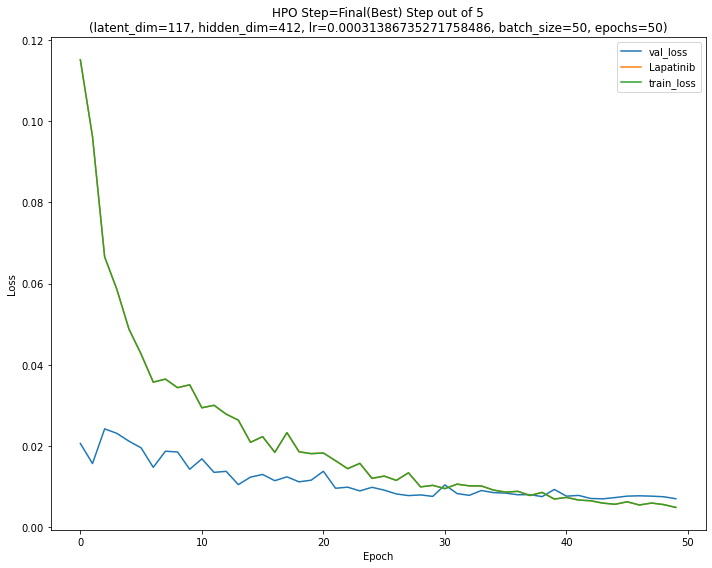

`Trainer.fit` stopped: `max_epochs=50` reached.


{'latent_dim': 117,
 'hidden_dim': 412,
 'lr': 0.00031386735271758486,
 'batch_size': 50,
 'epochs': 50}

In [7]:
model, best_params = tuner.perform_tuning()
best_params

In [19]:
model

DirectPred(
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1000, out_features=412, bias=True)
      (layer_out): Linear(in_features=412, out_features=117, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(412, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=157, out_features=412, bias=True)
      (layer_out): Linear(in_features=412, out_features=117, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(412, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (Lapatinib): MLP(
      (layer_1): Linear(in_features=234, out_features=412, bias=True)
      (layer_out): Linear(in_features=412, out_features=1, bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(412, eps=1e-0

In [8]:
y_pred_dict = model.predict(test_dataset)

In [9]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,Lapatinib,numerical,mse,0.005303
1,Lapatinib,numerical,r2,0.265643
2,Lapatinib,numerical,pearson_corr,0.583760


In [13]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 50)

In [18]:
top_features = flexynesis.get_important_features(model, "Lapatinib", top=40)


,target_variable,target_class,layer,name,importance
1064,Lapatinib,0,cnv,IKZF3,0.004854
1052,Lapatinib,0,cnv,FKBP5,0.004759
1029,Lapatinib,0,cnv,COL4A2,0.003510
1050,Lapatinib,0,cnv,FANCC,0.003441
1104,Lapatinib,0,cnv,PF4V1,0.003402
1082,Lapatinib,0,cnv,MGRN1,0.003292
1009,Lapatinib,0,cnv,ATP5ME,0.003256
1045,Lapatinib,0,cnv,EGFR,0.003248
1118,Lapatinib,0,cnv,RAPGEF6,0.003123
1091,Lapatinib,0,cnv,NFKBIA,0.002888


In [20]:
df.groupby(['target_class', 'layer']).apply(lambda x: x.nlargest(10, 'importance')).reset_index(drop=True)

NameError: name 'df' is not defined

In [45]:
df = flexynesis.subset_assays_by_features(test_dataset, top_features)
df

,cnv_IKZF3,cnv_ANK1,cnv_PAXIP1,cnv_BMP8B,cnv_RNASE2,cnv_ACVR2A,cnv_ADGRA2,cnv_LRRN3,cnv_EGFR,gex_ERBB2
0,-0.593340,-0.440137,-0.631603,-0.590942,-0.529911,-0.555490,-0.387989,-0.573468,-0.787927,-0.954082
1,-0.488768,1.007844,-0.824326,0.471090,-0.565055,0.587913,-0.479473,0.837710,0.515087,0.111149
2,0.246100,-1.005069,-1.325404,0.342003,1.248006,-0.871060,-0.841893,-1.147785,4.929775,0.721513
3,-0.510255,-0.511439,-0.614258,-0.514663,-0.637413,-0.555490,-0.456602,-0.717868,-0.813858,-0.984964
4,0.095689,-0.729002,0.411025,-0.291695,-0.104038,0.399867,-0.458362,0.420920,0.255780,0.080570
...,...,...,...,...,...,...,...,...,...,...
925,0.024064,-0.997756,0.214448,1.269080,0.055148,-12.179721,-0.924581,-1.082149,0.694980,-0.213058
926,-0.474443,0.514214,-0.762654,-0.557692,-0.432745,-0.486324,-1.976652,-0.347023,-0.024595,-0.537522
927,-0.103428,0.154047,1.168425,0.848571,0.950308,1.028847,0.183789,0.959137,0.753324,-0.078604
928,0.240370,1.230892,0.156632,1.210405,-0.389331,0.819187,1.220027,0.468507,0.087231,-0.368833


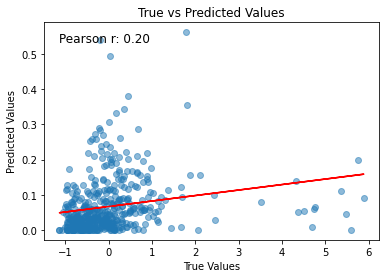

In [61]:
f = 'gex_ERBB2'
flexynesis.plot_scatter(df[f], test_dataset.ann['Erlotinib'])

In [47]:
response_category = flexynesis.split_by_median(test_dataset.ann['Lapatinib'])

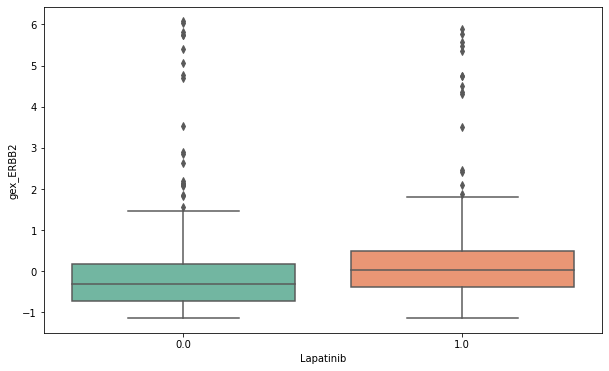

In [48]:
flexynesis.plot_boxplot(response_category, df[f], 'Lapatinib', f)

In [49]:
# get embeddings from training data
E = model.transform(test_dataset)

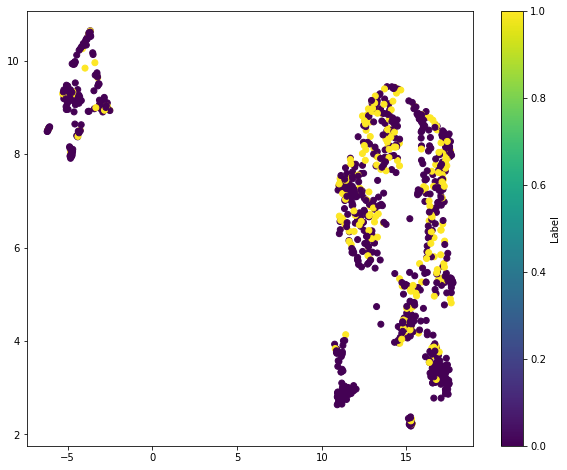

In [51]:
flexynesis.plot_dim_reduced(E, labels = response_category, method='umap', color_type='numerical')